In [1]:
import regex as re
import pandas as pd

from datasets import load_dataset
dataset = load_dataset("coastalcph/tydi_xor_rc")
df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()

print(f"Train size:",df_train["lang"].value_counts())
print(f"Validation size:",df_val["lang"].value_counts())



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: lang
bn    2598
ar    2558
ko    2422
ja    2301
fi    2126
ru    1983
te    1355
Name: count, dtype: int64
Validation size: lang
fi    528
bn    476
ja    456
ar    415
ru    396
te    384
ko    356
Name: count, dtype: int64


In [2]:
print("First Columns", df_train.head(1))

First Columns                                             question  \
0  উইকিলিকস কত সালে সর্বপ্রথম ইন্টারনেটে প্রথম তথ...   

                                             context lang  answerable  \
0  WikiLeaks () is an international non-profit or...   bn        True   

   answer_start answer answer_inlang  
0           182   2006          None  


In [3]:
print(df_train.columns.values)

['question' 'context' 'lang' 'answerable' 'answer_start' 'answer'
 'answer_inlang']


#### Checking Data Size

In [4]:
l = ["ar", "ko", "te", "en", "ja"]
df_train = df_train[df_train["lang"].isin(l)]
df_val = df_val[df_val["lang"].isin(l)]

In [5]:
print(f"Train Size: {df_train.shape}")
print(f"Validation Size: {df_val.shape}")

train_lan = df_train['lang'].value_counts()
val_len = df_val['lang'].value_counts()
print("Train Size per Language")
print(train_lan)
print("Validation Size per Language")
print(val_len) 

Train Size: (8636, 7)
Validation Size: (1611, 7)
Train Size per Language
lang
ar    2558
ko    2422
ja    2301
te    1355
Name: count, dtype: int64
Validation Size per Language
lang
ja    456
ar    415
te    384
ko    356
Name: count, dtype: int64


### Word Count

In [6]:
df_total = pd.concat([df_val, df_train], axis=0)
df_total.reset_index(drop=True)



#Different Dataframes for Stats use
ar, ko, te = df_total[df_total["lang"] == "ar"], df_total[df_total["lang"] == "ko"], df_total[df_total["lang"] == "te"]
ar_val, ko_val, te_val = df_val[df_val["lang"] == "ar"], df_val[df_val["lang"] == "ko"], df_val[df_val["lang"] == "te"]
ar_tra, ko_tra, te_tra = df_train[df_train["lang"] == "ar"], df_train[df_train["lang"] == "ko"], df_train[df_train["lang"] == "te"]

def word_list(df):
    words = [re.findall(r'\w+', quest) for quest in df["question"]]
    return [w for q in words for w in q]

def PrintWordCountStats(langs_df, labels, title):     
    langs_words = [word_list(l) for l in langs_df]
    print(title)
    for i in range(len(langs_words)):
            print(f"Word counts for {labels[i]}: {len(langs_words[i])}")
    print("-"*30)

labels = ["Arabic", "Korean", "Telugu"]

PrintWordCountStats([ar,ko,te], labels, "Word Counts Total Dataset")
PrintWordCountStats([ar_tra,ko_tra,te_tra], labels, "Word Counts Training Dataset")
PrintWordCountStats([ar_val,ko_val,te_val], labels, "Word Counts Validation Dataset")


Word Counts Total Dataset
Word counts for Arabic: 18819
Word counts for Korean: 13600
Word counts for Telugu: 9992
------------------------------
Word Counts Training Dataset
Word counts for Arabic: 16202
Word counts for Korean: 11863
Word counts for Telugu: 7690
------------------------------
Word Counts Validation Dataset
Word counts for Arabic: 2617
Word counts for Korean: 1737
Word counts for Telugu: 2302
------------------------------


### Token Count

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")


def token_count(text):
    return len(tokenizer.tokenize(text))

def PrintTokenCountStats(langs_df, labels, title):
    print(title)
    for i in range(len(langs_df)):
        print(f"Token counts for {labels[i]}: {langs_df[i]['question'].apply(token_count).sum()}")
    print("-"*30)

PrintTokenCountStats([ar, ko, te], labels, "Token Counts Total Dataset")
PrintTokenCountStats([ar_tra, ko_tra, te_tra], labels, "Token Counts Training Dataset")
PrintTokenCountStats([ar_val, ko_val, te_val], labels, "Token Counts Validation Dataset")

Token Counts Total Dataset
Token counts for Arabic: 39337
Token counts for Korean: 54
Token counts for Telugu: 23385
------------------------------
Token Counts Training Dataset
Token counts for Arabic: 33733
Token counts for Korean: 25829
Token counts for Telugu: 18365
------------------------------
Token Counts Validation Dataset
Token counts for Arabic: 5604
Token counts for Korean: 3775
Token counts for Telugu: 5020
------------------------------


### Most Common Words

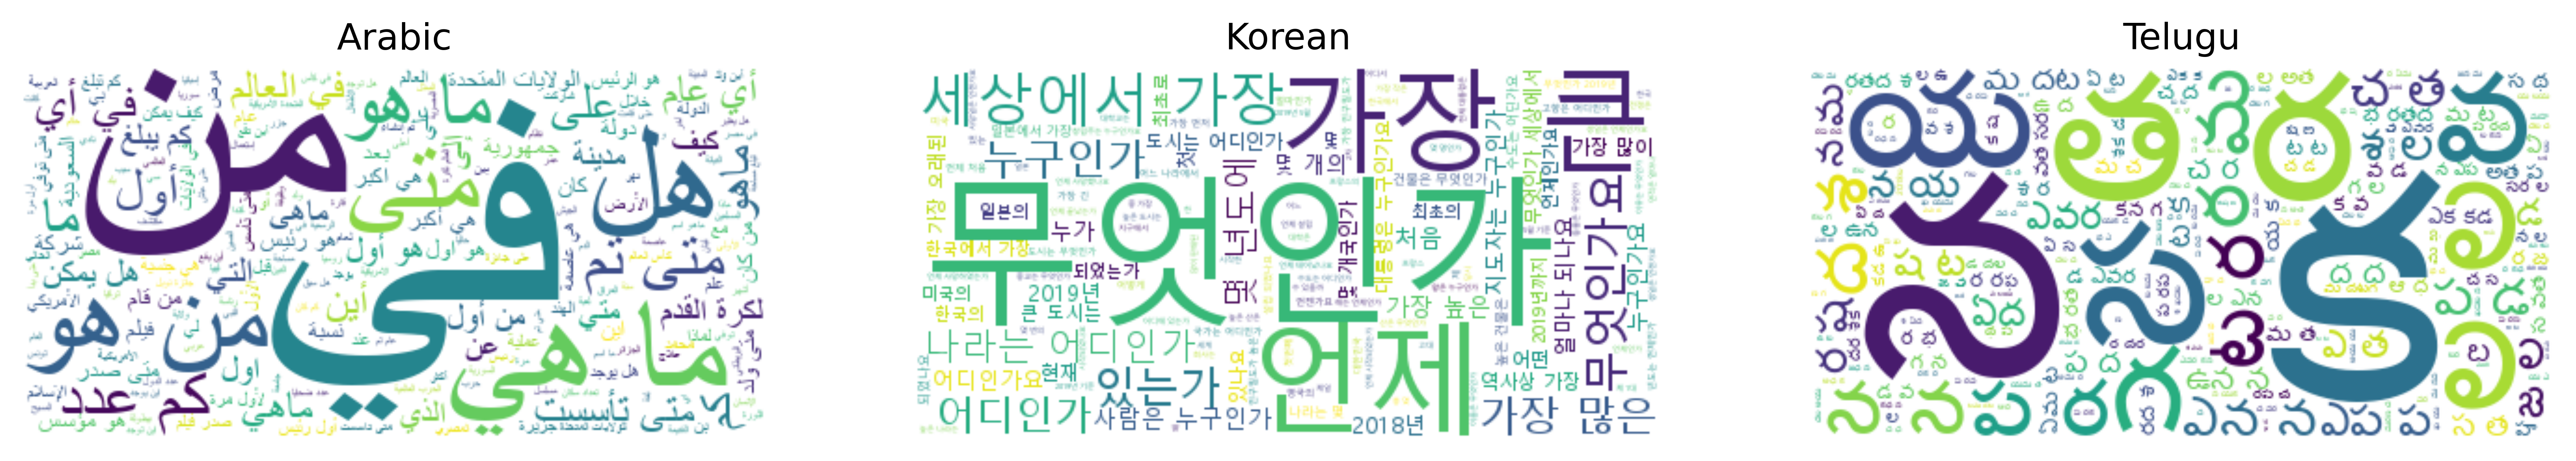

In [8]:
# 5 Most common words 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

ar_words, ko_words, te_words = word_list(ar), word_list(ko), word_list(te)

def CreateWordCloud(wordlist, font, arabic=False):
    wordlist = " ".join(wordlist)
    if arabic:
        wordlist = arabic_reshaper.reshape(wordlist)
        wordlist = get_display(wordlist)
    return WordCloud(font_path=font, background_color='white').generate(wordlist)

def DisplayWordClouds(w_clouds, labels):
    plt.figure(figsize=(5*len(w_clouds), 5), dpi=600)

    for i in range(len(w_clouds)):
        plt.subplot(1, 3, i+1)
        plt.imshow(w_clouds[i], interpolation='bilinear')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()


ar_wcloud = CreateWordCloud(ar_words, "arial.ttf", arabic=True)
ko_wcloud = CreateWordCloud(ko_words, "malgun.ttf")
te_wcloud = CreateWordCloud(te_words, "gautami.ttf")

DisplayWordClouds([ar_wcloud, ko_wcloud, te_wcloud], labels)

In [9]:
from collections import Counter

def get_top_words(word_list, n=5):
    counter = Counter(word_list)
    return counter.most_common(n)

def get_top_words_only(word_list, n=5):
    counter = Counter(word_list)
    return [word for word, count in counter.most_common(n)]

def print_top_words(word_list, language_name, n=5):
    counter = Counter(word_list)
    top_words = counter.most_common(n)
    
    print(f"\n{language_name} - Top {n} words:")
    print("-" * 40)
    for i, (word, count) in enumerate(top_words, 1):
        print(f"{i:2d}. '{word}': {count} occurrences")


ar_top5_with_counts = get_top_words(ar_words, 5)
ko_top5_with_counts = get_top_words(ko_words, 5)
te_top5_with_counts = get_top_words(te_words, 5)

ar_top5 = get_top_words_only(ar_words, 5)
ko_top5 = get_top_words_only(ko_words, 5)
te_top5 = get_top_words_only(te_words, 5)

print_top_words(ar_words, "Arabic", 5)
print_top_words(ko_words, "Korean", 5)
print_top_words(te_words, "Telugu", 5)


Arabic - Top 5 words:
----------------------------------------
 1. 'من': 700 occurrences
 2. 'في': 683 occurrences
 3. 'متى': 601 occurrences
 4. 'ما': 524 occurrences
 5. 'هو': 416 occurrences

Korean - Top 5 words:
----------------------------------------
 1. '가장': 593 occurrences
 2. '무엇인가': 572 occurrences
 3. '언제': 380 occurrences
 4. '어디인가': 257 occurrences
 5. '몇': 255 occurrences

Telugu - Top 5 words:
----------------------------------------
 1. 'ఎవరు': 348 occurrences
 2. 'ఏది': 268 occurrences
 3. 'ఏ': 236 occurrences
 4. 'ఎన్ని': 191 occurrences
 5. 'ఎప్పుడు': 185 occurrences


In [10]:
ar_top5 = get_top_words_only(ar_words, 5)
ko_top5 = get_top_words_only(ko_words, 5)   
te_top5 = get_top_words_only(te_words, 5)

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
import torch

torch.set_default_device("cpu")

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

def TranslateWord(words, lang):
    langs = {"Arabic":"ara_Arab", "Korean":"kor_Hang", "Telegu":"tel_Telu", "Japanese":"jpn_Jpan"}

    if lang not in langs.keys():
        print(f"No Language {lang}")
        return
    
    tokenizer.src_lang = langs[lang]
    inputs = tokenizer(words, return_tensors="pt", padding=True)
    forced_bos_token_id = tokenizer.convert_tokens_to_ids("eng_Latn")
    outputs = model.generate(**inputs, forced_bos_token_id=forced_bos_token_id)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

def getExampleSentence(df, word):
    questions = df["question"].tolist()
    return next(q for q in questions if word in q)

def printTranslationCheck(words, df, lang):
    wl = [w[0] for w in words]
    ko_top5_en = TranslateWord(wl, lang)
    ex_sent = [getExampleSentence(df, w) for w in wl]
    ex_sent_en = [TranslateWord(w, lang) for w in ex_sent]

    for i,_ in enumerate(range(len(ko_top5))):
        print(f"#{words[i][1]} - {words[i][0]} : {ko_top5_en[i]} -> {ex_sent[i]} : {ex_sent_en[i]}")

printTranslationCheck(ko_top5_with_counts, ko, "Korean")

#593 - 가장 : The most -> 지구에서 가장 가까운 행성은 무엇인가? : ['What is the closest planet to Earth?']
#572 - 무엇인가 : Something. -> 1887년 케이스 웨스턴 리저브 대학의 이름은 무엇인가? : ['What was the name of Case Western Reserve University in 1887?']
#380 - 언제 : When? -> 앤드류 유진 페티트의 마지막 경기 날짜는 언제인가요? : ["When is Andrew Eugene Petit's last game?"]
#257 - 어디인가 : Where are you? -> 세상에서 가장 큰 가톨릭 성당은 어디인가? : ['Where is the largest Catholic church in the world?']
#255 - 몇 : A few. -> 북유럽의 노르딕 국가는 몇개인가요? : ['How many Nordic countries in northern Europe?']


### Translation

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

ko = ko.sample(5)
print(ko["question"].tolist())

tokenizer.src_lang = "kor_Hang"
inputs = tokenizer(ko["question"].tolist(), return_tensors="pt", padding=True)
forced_bos_token_id = tokenizer.convert_tokens_to_ids("eng_Latn")

outputs = model.generate(**inputs, forced_bos_token_id=forced_bos_token_id)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))


['푸른이구아나가 처음 발견된 년도는 언제인가?', '미국 마이애미주에는 몇개의 도시가 있나요?', '시리아에서 가장 높은 산은 무엇인가?', '도싯 주의 표어는 무엇인가요?', '독일 국회의사당은 어떤 양식의 건물인가요?']
['When was the first year that the blue iguana was discovered?', 'How many cities in Miami, USA?', 'What is the highest mountain in Syria?', "What's the symbol of the Doge's?", 'What kind of building is the German Parliament?']


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')      
nltk.download('wordnet')    
nltk.download('omw-1.4') 
nltk.download('averaged_perceptron_tagger_eng')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

splits = {'train': 'train.parquet', 'validation': 'validation.parquet'}
df_val = pd.read_parquet("hf://datasets/coastalcph/tydi_xor_rc/" + splits["validation"])

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

device = "mps"
#device = "cuda"
#device = "cpu"
model.to(device)

lang_codes = {
    "ar": "ara_Arab", 
    "ko": "kor_Hang", 
    "te": "tel_Telu",
}

def translate_to_en(texts, src_lang):
    tokenizer.src_lang = lang_codes[src_lang]
    outputs = []
    
    for i in tqdm(range(0, len(texts), 8), desc=f"Translating {src_lang}"):
        batch = texts[i:i+8]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        
        bos_token_id = tokenizer.convert_tokens_to_ids("eng_Latn")
        
        out = model.generate(**inputs, forced_bos_token_id=bos_token_id)
        outputs.extend(tokenizer.batch_decode(out, skip_special_tokens=True))
    
    return outputs

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = text.split()
    stopwords = {"the","a","an","this","that","those",      # articles
    "is","was","has","have","had","be",                     # verbs
    "been","do","does","did","are","were",
    "go","went","goes",                   
    "in","on","at","of","to","for","with",                  # prepositions
    "into","from","above","below","before","after",
    "and","or","but",                                       # conjunctions
    "there","their","its","it",                             # possessive/pronouns
    "who","what","when","where","why","how","which"         # question words
    }
    return set(lemmatizer.lemmatize(t) for t in tokens if t not in stopwords)

def predict_answerable(question, context):
    a = preprocess(question)
    b = preprocess(context)
    
    return 1 if len(a & b) / len(a) >= 0.5 else 0
    # return 1 if len(preprocess(question) & preprocess(context)) > 1 else 0    # any token 
    # return 1 if set(a) <= set(b) else 0                                       # all tokens

results = {}

for lang in ["ar", "ko", "te"]:
    subset = df_val[df_val["lang"] == lang].copy()
    
    subset["question_en"] = translate_to_en(subset["question"].tolist(), lang)
    subset["context_en"] = translate_to_en(subset["context"].tolist(), lang)
    
    subset["pred"] = [predict_answerable(q, c) for q, c in tqdm(zip(subset["question_en"], subset["context_en"]), total=len(subset), desc=f"Predicting {lang}")]
    
    acc = accuracy_score(subset["answerable"], subset["pred"])
    prec, rec, f1, _ = precision_recall_fscore_support(subset["answerable"], subset["pred"], average="binary")
    
    results[lang] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

print("Performance by language:")
for lang, metrics in results.items():
    print(f"\nLanguage: {lang}")
    print(f"Accuracy : {metrics['accuracy']:.4f}")
    print(f"F1 Score : {metrics['f1']:.4f}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sarene/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sarene/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sarene/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sarene/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
Predicting te: 100%|██████████| 384/384 [00:00<00:00, 1028.16it/s]


Performance by language:

Language: ar
Accuracy : 0.5663
F1 Score : 0.7000

Language: ko
Accuracy : 0.5225
F1 Score : 0.6731

Language: te
Accuracy : 0.6641
F1 Score : 0.7514


In [15]:
print("\n" + "="*80)
print("Unanswerable Questions (translated to English) for token comparison")
print("="*80)

for lang in ["ar", "ko", "te"]:
    subset = df_val[df_val["lang"] == lang].copy()
    subset["question_en"] = translate_to_en(subset["question"].tolist(), lang)
    subset["context_en"] = translate_to_en(subset["context"].tolist(), lang)
    subset["pred"] = [predict_answerable(q, c) for q, c in zip(subset["question_en"], subset["context_en"])]

    unans = subset[subset["pred"] == 0]

    print(f"\n--- {lang.upper()} ({len(unans)}) unanswerable predictions ---")
    for i, row in unans.iterrows():
        q_tokens = preprocess(row["question_en"])
        c_tokens = preprocess(row["context_en"])
        overlap = q_tokens & c_tokens

        print(f"\nQuestion (EN): {row['question_en']}")
        print(f"Context (EN): {row['context_en'][:300]}...")  # truncate for readability
        print(f"→ Question tokens: {sorted(list(q_tokens))}")
        print(f"→ Context tokens: {sorted(list(c_tokens))[:30]} ...")
        print(f"→ Overlap tokens: {sorted(list(overlap))}")
        print("-" * 80)


Unanswerable Questions (translated to English) with token comparison


Translating ar: 100%|██████████| 52/52 [05:20<00:00,  6.15s/it]



--- AR (178) unanswerable predictions ---

Question (EN): Has the son of a Yemeni duck ever visited?
Context (EN): After the "hajj" in either 1328 or 1330, he made his way to the port of Jeddah on the Red Sea coast.From there he followed the coast in a series of boats making slow progress against the prevailing south-east winds.Once in Yemen he visited Zabīd and later the highland town of Ta'izz, where he met th...
→ Question tokens: ['duck', 'ever', 'son', 'visited', 'yemeni']
→ Context tokens: ['1328', '1329', '1330', '1331', 'actually', 'aden', 'against', 'aldin', 'aliibn', 'all', 'also', 'around', 'arriving', 'battuta', 'beginning', 'boat', 'coast', 'coastfrom', 'directly', 'doubtfulin', 'dynasty', 'either', 'followed', 'hajj', 'he', 'highland', 'his', 'important', 'jeddah', 'king'] ...
→ Overlap tokens: ['visited']
--------------------------------------------------------------------------------

Question (EN): When did the Normandy War end?
Context (EN): The Allies planned to lau

Translating ko: 100%|██████████| 45/45 [04:19<00:00,  5.77s/it]



--- KO (173) unanswerable predictions ---

Question (EN): What country is Omni religion in?
Context (EN): These letters are believed to have derived from an Egyptian hieroglyph depicting an ox's head. The Phoenician variant gave rise to the Greek Alpha (Α), being re-interpreted to express not the glottal consonant but the accompanying vowel, and hence the Latin A and Cyrillic А....
→ Question tokens: ['country', 'omni', 'religion']
→ Context tokens: ['accompanying', 'alpha', 'being', 'believed', 'consonant', 'cyrillic', 'depicting', 'derived', 'egyptian', 'express', 'gave', 'glottal', 'greek', 'head', 'hence', 'hieroglyph', 'latin', 'letter', 'not', 'ox', 'phoenician', 'reinterpreted', 'rise', 'these', 'variant', 'vowel'] ...
→ Overlap tokens: []
--------------------------------------------------------------------------------

Question (EN): What's the size of Dallas?
Context (EN): Portions of the city extend into neighboring Collin, Denton, Kaufman, and Rockwall counties. According t

Translating te: 100%|██████████| 48/48 [04:21<00:00,  5.46s/it]


--- TE (156) unanswerable predictions ---

Question (EN): What is the average amount of blood a person needs?
Context (EN): A typical adult has a blood volume of approximately 5 liters, with females and males having approximately the same blood volume....
→ Question tokens: ['amount', 'average', 'blood', 'need', 'person']
→ Context tokens: ['5', 'adult', 'approximately', 'blood', 'female', 'having', 'liter', 'male', 'same', 'typical', 'volume'] ...
→ Overlap tokens: ['blood']
--------------------------------------------------------------------------------

Question (EN): In what year was television invented?
Context (EN): John Logie Baird (; 13 August 1888 - 14 June 1946) was a Scottish engineer, innovator, one of the inventors of the mechanical television, demonstrating the first working television system on 26 January 1926, and inventor of both the first publicly demonstrated colour television system, and the first...
→ Question tokens: ['invented', 'television', 'year']
→ Context t